# Notebook 3 — EMD decomposition (one series) + saved figure

Этот ноутбук:
1) загружает один ряд из `data/final_features_all.parquet` (по умолчанию `I_t` для AAPL);
2) делает EMD-разложение (IMFs);
3) сохраняет **одну** картинку в `outputs/emd_<ticker>_<series>.png`;
4) печатает таблицу с долей дисперсии (energy) по IMF — удобно для интерпретации.


In [1]:
# (Опционально) ставим PyEMD, если нет
import importlib, sys, subprocess

def pip_install(pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + pkgs)

try:
    from PyEMD import EMD
except Exception:
    pip_install(["EMD-signal"])  # пакет PyEMD часто ставится так
    from PyEMD import EMD

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = Path("outputs")
OUT_DIR.mkdir(exist_ok=True)

DATA_DIR = Path("data")


In [2]:
# --- Robust parquet loader (как в Notebook 2) ---
_PARQUET_ENGINE = None
try:
    import fastparquet  # noqa: F401
    _PARQUET_ENGINE = "fastparquet"
except Exception:
    _PARQUET_ENGINE = "pyarrow"

def _reset_pyarrow_pandas_ext_types():
    try:
        import pyarrow as pa
    except Exception:
        return
    for name in ("pandas.period", "pandas.interval"):
        try:
            pa.unregister_extension_type(name)
        except Exception:
            pass

def safe_read_parquet(path: Path) -> pd.DataFrame:
    try:
        return pd.read_parquet(path, engine=_PARQUET_ENGINE)
    except Exception as e:
        msg = str(e)
        if ("type extension with name pandas." in msg and "already defined" in msg) or "ArrowKeyError" in msg:
            _reset_pyarrow_pandas_ext_types()
            return pd.read_parquet(path, engine=_PARQUET_ENGINE)
        raise

print("Parquet engine:", _PARQUET_ENGINE)


Parquet engine: fastparquet


In [3]:
# --- Choose series for EMD ---
df = safe_read_parquet(DATA_DIR / "final_features_all.parquet").copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["ticker","date"]).reset_index(drop=True)

ticker = "AAPL"   # поменяйте при желании
series_name = "I_t"  # "I_t" или "r_log" и т.п.

g = df[df["ticker"] == ticker].copy().sort_values("date")

# если ряда нет — fallback на returns (log(1+returns))
if series_name not in g.columns:
    print(f"Series '{series_name}' not found. Falling back to 'returns' -> log1p.")
    series_name = "r_log"
    g["r_log"] = np.log1p(pd.to_numeric(g["returns"], errors="coerce"))

x = pd.to_numeric(g[series_name], errors="coerce").astype(float).values
mask = np.isfinite(x)
g = g.loc[mask].copy()
x = x[mask]

print("ticker:", ticker, "| series:", series_name, "| n:", len(x))
g.head()


ticker: AAPL | series: I_t | n: 719


,ticker,date,returns,RSI,MACD,I_t
1,AAPL,2020-12-29,-0.013315,0.000000,-0.141332,-0.215098
2,AAPL,2020-12-30,-0.008527,0.000000,-0.339756,-0.811591
4,AAPL,2021-01-04,-0.024719,0.000000,-1.000952,0.927804
5,AAPL,2021-01-05,0.012364,6.299510,-1.201901,0.254013
6,AAPL,2021-01-06,-0.033662,5.307127,-1.688099,0.147563


In [4]:
# --- Run EMD ---
emd = EMD()
imfs = emd.emd(x)

if imfs is None or len(imfs) == 0:
    raise RuntimeError("EMD returned no IMFs (series might be too short/flat).")

imfs = np.asarray(imfs)
residual = x - imfs.sum(axis=0)

print("IMFs:", imfs.shape[0], "len:", imfs.shape[1])

# Energy share per IMF (variance-based)
energies = np.var(imfs, axis=1)
total = float(np.var(x))
share = energies / total if total > 0 else np.nan

energy_tbl = pd.DataFrame({
    "imf": [f"IMF{i+1}" for i in range(imfs.shape[0])],
    "var_share": share
}).sort_values("imf")

energy_tbl


IMFs: 9 len: 719


,imf,var_share
0,IMF1,0.616600
1,IMF2,0.197748
2,IMF3,0.093695
3,IMF4,0.042179
4,IMF5,0.018647
5,IMF6,0.012000
6,IMF7,0.011909
7,IMF8,0.018939
8,IMF9,0.002246


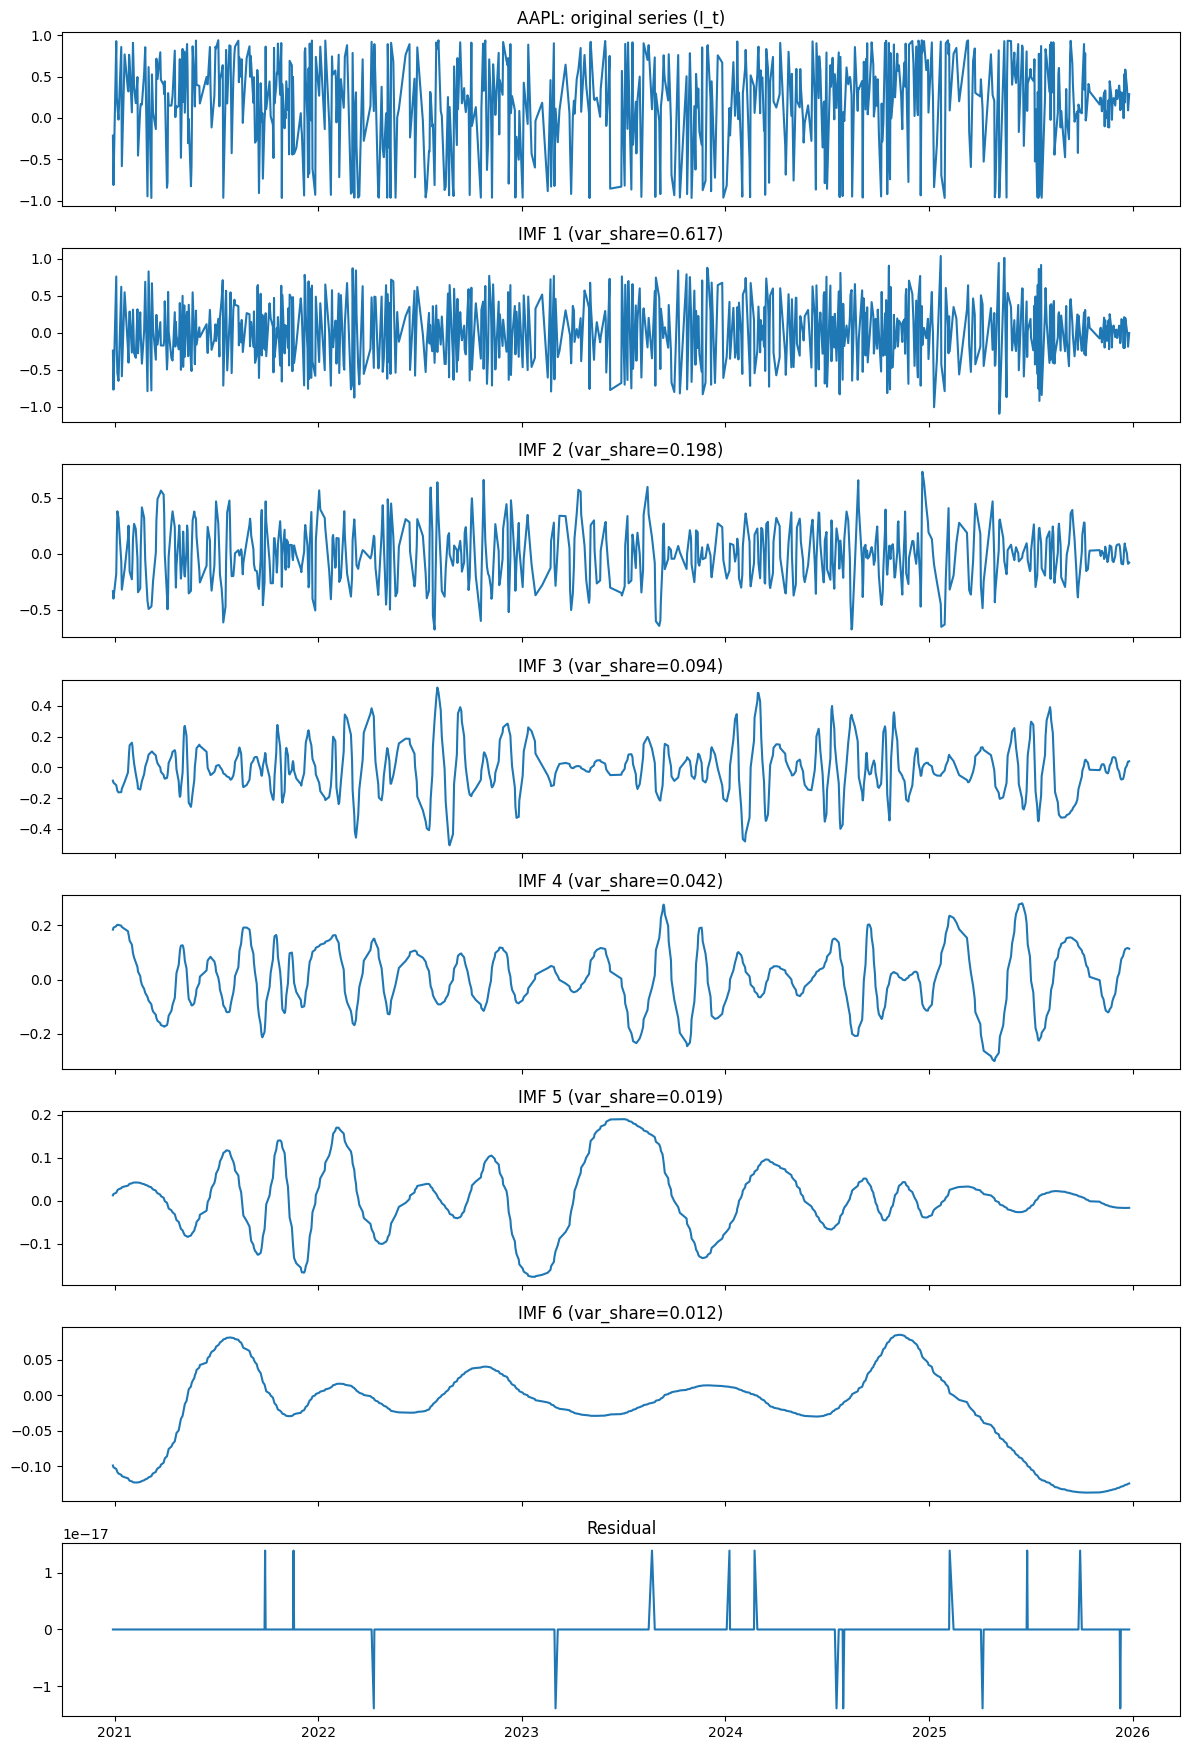

Saved: outputs/emd_AAPL_I_t.png


In [5]:
# --- Plot (ONE figure) and save ---
n_imf = imfs.shape[0]
n_show = min(6, n_imf)  # показываем до 6 IMFs, чтобы фигура была читаемой

n_rows = 2 + n_show  # original + IMFs + residual
fig, axes = plt.subplots(n_rows, 1, figsize=(12, 2.2*n_rows), sharex=True)

dates = g["date"].values

axes[0].plot(dates, x)
axes[0].set_title(f"{ticker}: original series ({series_name})")

for i in range(n_show):
    axes[i+1].plot(dates, imfs[i])
    axes[i+1].set_title(f"IMF {i+1} (var_share={energy_tbl.loc[energy_tbl['imf']==f'IMF{i+1}','var_share'].values[0]:.3f})")

axes[n_show+1].plot(dates, residual)
axes[n_show+1].set_title("Residual")

fig.tight_layout()
out_path = OUT_DIR / f"emd_{ticker}_{series_name}.png"
fig.savefig(out_path, dpi=150)
plt.show()

print("Saved:", out_path)


Готово ✅  

- Картинка EMD сохранена в `outputs/emd_<ticker>_<series>.png`.
- Таблица `var_share` по IMF помогает написать интерпретацию: первые IMFs обычно более высокочастотные (шум/реакции), последние — низкочастотные (режим/тренд).
